In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from imblearn.over_sampling import SMOTE, ADASYN
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import tensorflow as tf

# Pastikan TensorFlow mendeteksi GPU
print("TensorFlow Version:", tf.__version__)
if tf.test.gpu_device_name():
    print("GPU tersedia:", tf.test.gpu_device_name())
else:
    print("GPU tidak terdeteksi. Pastikan runtime menggunakan GPU.")


TensorFlow Version: 2.17.0
GPU tersedia: /device:GPU:0


In [3]:
import pandas as pd

# Path ke dataset
file_path = '/kaggle/input/netflow-dl/NF-ToN-IoT-v2.csv'

# Baca dataset
df = pd.read_csv(file_path)

# Tampilkan informasi awal dataset
print(f"Dataset asli memiliki {df.shape[0]} baris dan {df.shape[1]} kolom.")

# Langkah 1: Pilih Kolom Numerik
numerical_columns = df.select_dtypes(include=['number']).columns.tolist()

# Pastikan kolom 'Label' ada di kolom numerik
if 'Label' not in numerical_columns:
    raise ValueError("Kolom 'Label' tidak ditemukan sebagai kolom numerik!")

# Langkah 2: Analisis Korelasi
# Hitung korelasi absolut antara setiap kolom numerik dan target ('Label')
correlation_with_label = df[numerical_columns].corr()['Label'].abs().sort_values(ascending=False)

# Tampilkan korelasi untuk referensi
print("\nKorelasi dengan kolom 'Label':")
print(correlation_with_label)

# Ambil kolom dengan korelasi > 0.1 (threshold dapat disesuaikan)
important_columns = correlation_with_label[correlation_with_label > 0.1].index.tolist()
print(f"\nKolom penting berdasarkan korelasi (> 0.1): {important_columns}")

# Langkah 3: Sampling 20% Data
# Ambil 20% data secara acak
sampled_df = df.sample(frac=0.2, random_state=42)

# Langkah 4: Tampilkan Hasil
print(f"\nDataset setelah sampling 20%: {sampled_df.shape}")
print("Beberapa baris pertama dari dataset hasil sampling:")
sampled_df[important_columns].head()


Dataset asli memiliki 16940496 baris dan 45 kolom.

Korelasi dengan kolom 'Label':
Label                          1.000000
TCP_WIN_MAX_IN                 0.358672
CLIENT_TCP_FLAGS               0.340318
MIN_IP_PKT_LEN                 0.326147
TCP_WIN_MAX_OUT                0.315930
MIN_TTL                        0.286961
MAX_TTL                        0.285889
MAX_IP_PKT_LEN                 0.252001
LONGEST_FLOW_PKT               0.252001
SERVER_TCP_FLAGS               0.219127
FLOW_DURATION_MILLISECONDS     0.201247
TCP_FLAGS                      0.201004
PROTOCOL                       0.123348
DNS_QUERY_ID                   0.121797
DNS_TTL_ANSWER                 0.111837
L4_DST_PORT                    0.106477
DURATION_OUT                   0.102323
SRC_TO_DST_AVG_THROUGHPUT      0.091341
L7_PROTO                       0.089257
DURATION_IN                    0.069607
SHORTEST_FLOW_PKT              0.069592
DST_TO_SRC_AVG_THROUGHPUT      0.057341
DNS_QUERY_TYPE                 0.0500

,Label,TCP_WIN_MAX_IN,CLIENT_TCP_FLAGS,MIN_IP_PKT_LEN,TCP_WIN_MAX_OUT,MIN_TTL,MAX_TTL,MAX_IP_PKT_LEN,LONGEST_FLOW_PKT,SERVER_TCP_FLAGS,FLOW_DURATION_MILLISECONDS,TCP_FLAGS,PROTOCOL,DNS_QUERY_ID,DNS_TTL_ANSWER,L4_DST_PORT,DURATION_OUT
14986849,1,29200,27,40,65535,64,64,1500,1500,27,4294733,27,6,0,0,80,234
12674436,1,29200,18,52,28960,64,64,60,60,19,4294904,19,6,0,0,443,63
3630246,1,4096,2,0,0,0,0,48,48,0,0,2,6,0,0,25720,0
11281219,1,29200,27,52,26847,64,64,1500,1500,27,0,27,6,0,0,80,0
5679904,0,1024,2,0,0,0,0,44,44,0,0,2,6,0,0,5544,0


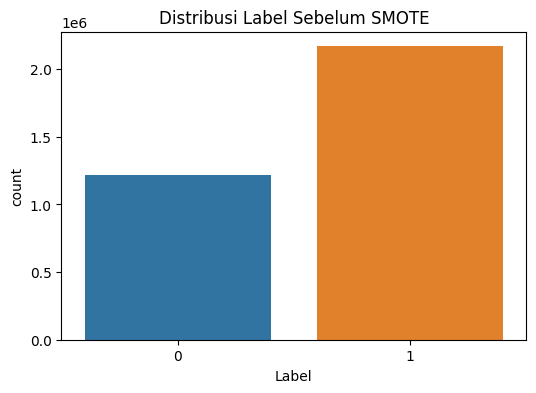

In [4]:
# 7. Visualisasi Distribusi Label (Target)
if 'Label' in sampled_df.columns:
    plt.figure(figsize=(6, 4))
    sns.countplot(x='Label', data=sampled_df)
    plt.title("Distribusi Label Sebelum SMOTE")
    plt.show()

In [5]:
print("Jumlah Missing Values Sebelum Cleaning:")
print(sampled_df.isnull().sum())


Jumlah Missing Values Sebelum Cleaning:
IPV4_SRC_ADDR                  0
L4_SRC_PORT                    0
IPV4_DST_ADDR                  0
L4_DST_PORT                    0
PROTOCOL                       0
L7_PROTO                       0
IN_BYTES                       0
IN_PKTS                        0
OUT_BYTES                      0
OUT_PKTS                       0
TCP_FLAGS                      0
CLIENT_TCP_FLAGS               0
SERVER_TCP_FLAGS               0
FLOW_DURATION_MILLISECONDS     0
DURATION_IN                    0
DURATION_OUT                   0
MIN_TTL                        0
MAX_TTL                        0
LONGEST_FLOW_PKT               0
SHORTEST_FLOW_PKT              0
MIN_IP_PKT_LEN                 0
MAX_IP_PKT_LEN                 0
SRC_TO_DST_SECOND_BYTES        0
DST_TO_SRC_SECOND_BYTES        0
RETRANSMITTED_IN_BYTES         0
RETRANSMITTED_IN_PKTS          0
RETRANSMITTED_OUT_BYTES        0
RETRANSMITTED_OUT_PKTS         0
SRC_TO_DST_AVG_THROUGHPUT      0
DST

In [4]:
# Pre-processing
# Menghapus kolom yang tidak relevan (IPV4_SRC_ADDR dan IPV4_DST_ADDR jika tidak dibutuhkan)
columns_to_drop = ['IPV4_SRC_ADDR', 'IPV4_DST_ADDR']  # Kolom alamat IP tidak dipakai
sampled_df = sampled_df.drop(columns=columns_to_drop, axis=1)

In [5]:
# Encoding kolom kategorikal (Attack) menggunakan LabelEncoder
if 'Attack' in sampled_df.columns:
    encoder = LabelEncoder()
    sampled_df['Attack'] = encoder.fit_transform(sampled_df['Attack'])


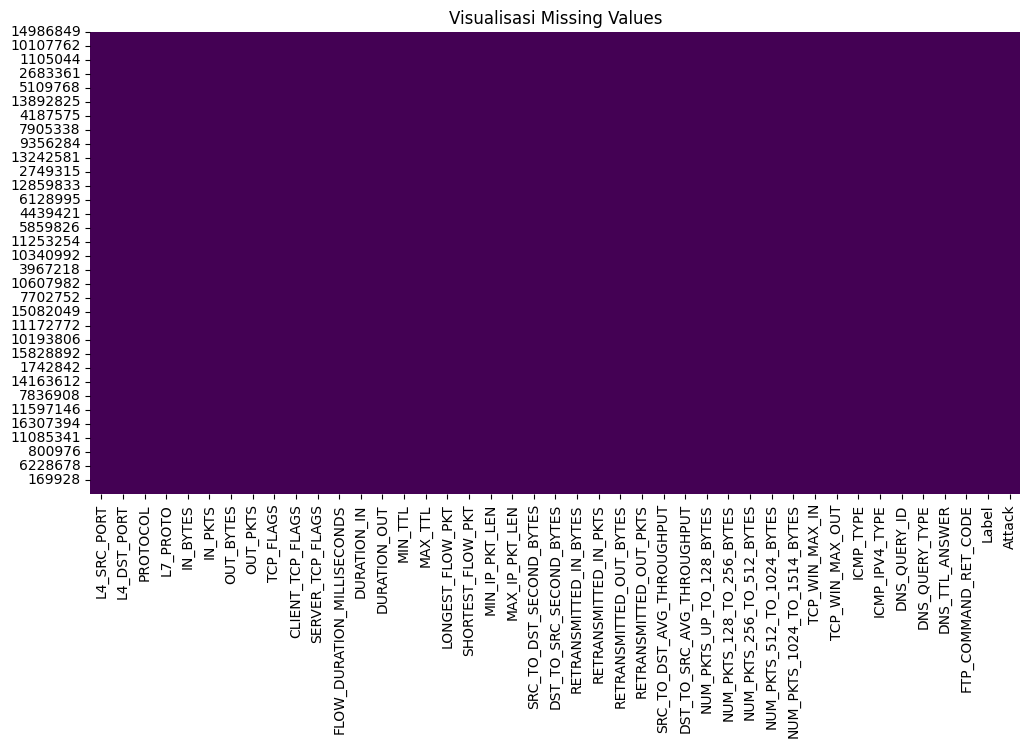

In [8]:
# 3. Visualisasi Missing Values
plt.figure(figsize=(12, 6))
sns.heatmap(sampled_df.isnull(), cbar=False, cmap='viridis')
plt.title("Visualisasi Missing Values")
plt.show()

In [9]:
sampled_df.describe()


/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py:1010: RuntimeWarning: overflow encountered in square
  sqr = _ensure_numeric((avg - values) ** 2)
/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py:1010: RuntimeWarning: overflow encountered in square
  sqr = _ensure_numeric((avg - values) ** 2)


,L4_SRC_PORT,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,IN_PKTS,OUT_BYTES,OUT_PKTS,TCP_FLAGS,CLIENT_TCP_FLAGS,...,TCP_WIN_MAX_IN,TCP_WIN_MAX_OUT,ICMP_TYPE,ICMP_IPV4_TYPE,DNS_QUERY_ID,DNS_QUERY_TYPE,DNS_TTL_ANSWER,FTP_COMMAND_RET_CODE,Label,Attack
count,3.388099e+06,3.388099e+06,3.388099e+06,3.388099e+06,3.388099e+06,3.388099e+06,3.388099e+06,3.388099e+06,3.388099e+06,3.388099e+06,...,3.388099e+06,3.388099e+06,3.388099e+06,3.388099e+06,3.388099e+06,3.388099e+06,3.388099e+06,3.388099e+06,3.388099e+06,3.388099e+06
mean,4.335085e+04,9.278744e+03,7.614466e+00,1.376004e+01,7.413247e+02,6.384517e+00,7.852113e+02,3.197755e+00,1.279844e+01,9.488883e+00,...,1.064391e+04,1.037632e+04,4.283939e+02,1.673412e+00,4.655062e+03,1.543087e+00,4.160298e+03,1.471426e+00,6.402133e-01,4.032970e+00
std,1.517192e+04,1.685084e+04,3.924271e+00,3.199413e+01,1.752014e+05,5.730695e+02,7.771521e+04,3.268014e+02,1.127850e+01,1.090704e+01,...,1.354355e+04,1.803104e+04,4.096069e+03,1.600027e+01,1.349326e+04,8.669901e+00,4.758855e+04,2.580322e+01,4.799378e-01,3.709469e+00
min,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,4.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.732300e+04,8.000000e+01,6.000000e+00,0.000000e+00,4.400000e+01,1.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,2.000000e+00,...,1.024000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,4.576900e+04,4.430000e+02,6.000000e+00,0.000000e+00,5.200000e+01,1.000000e+00,4.000000e+01,1.000000e+00,1.700000e+01,2.000000e+00,...,1.024000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,3.000000e+00
75%,5.421400e+04,8.080000e+03,6.000000e+00,7.000000e+00,2.760000e+02,4.000000e+00,1.800000e+02,3.000000e+00,2.200000e+01,1.800000e+01,...,2.920000e+04,2.896000e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,8.000000e+00
max,6.553500e+04,6.553500e+04,5.800000e+01,2.480000e+02,3.019262e+08,4.692810e+05,9.693209e+07,3.689140e+05,2.230000e+02,2.230000e+02,...,6.553500e+04,6.553500e+04,6.528000e+04,2.550000e+02,6.553500e+04,2.550000e+02,3.600000e+06,5.530000e+02,1.000000e+00,9.000000e+00


In [6]:
X = sampled_df.drop(columns=['Label'], axis=1)  # Semua kolom kecuali target (Label)
y = sampled_df['Label']  # Target


In [29]:
sampled_df.dtypes

L4_SRC_PORT                      int64
L4_DST_PORT                      int64
PROTOCOL                         int64
L7_PROTO                       float64
IN_BYTES                         int64
IN_PKTS                          int64
OUT_BYTES                        int64
OUT_PKTS                         int64
TCP_FLAGS                        int64
CLIENT_TCP_FLAGS                 int64
SERVER_TCP_FLAGS                 int64
FLOW_DURATION_MILLISECONDS       int64
DURATION_IN                      int64
DURATION_OUT                     int64
MIN_TTL                          int64
MAX_TTL                          int64
LONGEST_FLOW_PKT                 int64
SHORTEST_FLOW_PKT                int64
MIN_IP_PKT_LEN                   int64
MAX_IP_PKT_LEN                   int64
SRC_TO_DST_SECOND_BYTES        float64
DST_TO_SRC_SECOND_BYTES        float64
RETRANSMITTED_IN_BYTES           int64
RETRANSMITTED_IN_PKTS            int64
RETRANSMITTED_OUT_BYTES          int64
RETRANSMITTED_OUT_PKTS   

In [7]:
std_devs = X.std()
if any(std_devs == 0):
    print("Menghapus kolom konstan:")
    print(std_devs[std_devs == 0])
    X = X.drop(columns=std_devs[std_devs == 0].index)

/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py:1010: RuntimeWarning: overflow encountered in square
  sqr = _ensure_numeric((avg - values) ** 2)


In [8]:
# Langkah 2: Tambahkan noise kecil untuk kolom konstan (opsional)
for col in X.columns:
    if X[col].std() == 0:
        X[col] += np.random.normal(0, 1e-6, size=X[col].shape)

In [9]:
print("Jumlah nilai 0.0 di setiap kolom:")
zero_counts = (X == 0.0).sum()
print(zero_counts)

for col in X.columns:
    if zero_counts[col] > 0:  # Jika ada nilai 0.0
        median_value = X[col].median()  # Hitung median kolom
        if median_value == 0:  # Jika median adalah 0
            mean_value = X[col].mean()  # Hitung modus kolom
            X[col] = X[col].replace(0.0, mean_value)  # Ganti 0.0 dengan modus
        else:
            X[col] = X[col].replace(0.0, median_value)  # Ganti 0.0 dengan median

Jumlah nilai 0.0 di setiap kolom:
L4_SRC_PORT                       4530
L4_DST_PORT                       4954
PROTOCOL                             0
L7_PROTO                       2058398
IN_BYTES                             0
IN_PKTS                              0
OUT_BYTES                      1254071
OUT_PKTS                       1254071
TCP_FLAGS                       502528
CLIENT_TCP_FLAGS                502536
SERVER_TCP_FLAGS               1718355
FLOW_DURATION_MILLISECONDS     2763000
DURATION_IN                    2853629
DURATION_OUT                   2872101
MIN_TTL                        2177322
MAX_TTL                        2177322
LONGEST_FLOW_PKT                     0
SHORTEST_FLOW_PKT                    0
MIN_IP_PKT_LEN                 1254056
MAX_IP_PKT_LEN                       0
SRC_TO_DST_SECOND_BYTES              2
DST_TO_SRC_SECOND_BYTES        1254058
RETRANSMITTED_IN_BYTES         3335214
RETRANSMITTED_IN_PKTS          3335214
RETRANSMITTED_OUT_BYTES       

In [10]:
print("Jumlah nilai 0.0 di setiap kolom:")
zero_counts = (X == 0.0).sum()
print(zero_counts)


Jumlah nilai 0.0 di setiap kolom:
L4_SRC_PORT                    0
L4_DST_PORT                    0
PROTOCOL                       0
L7_PROTO                       0
IN_BYTES                       0
IN_PKTS                        0
OUT_BYTES                      0
OUT_PKTS                       0
TCP_FLAGS                      0
CLIENT_TCP_FLAGS               0
SERVER_TCP_FLAGS               0
FLOW_DURATION_MILLISECONDS     0
DURATION_IN                    0
DURATION_OUT                   0
MIN_TTL                        0
MAX_TTL                        0
LONGEST_FLOW_PKT               0
SHORTEST_FLOW_PKT              0
MIN_IP_PKT_LEN                 0
MAX_IP_PKT_LEN                 0
SRC_TO_DST_SECOND_BYTES        0
DST_TO_SRC_SECOND_BYTES        0
RETRANSMITTED_IN_BYTES         0
RETRANSMITTED_IN_PKTS          0
RETRANSMITTED_OUT_BYTES        0
RETRANSMITTED_OUT_PKTS         0
SRC_TO_DST_AVG_THROUGHPUT      0
DST_TO_SRC_AVG_THROUGHPUT      0
NUM_PKTS_UP_TO_128_BYTES       0
NUM_PKTS_

In [61]:
X = X.fillna(X.median())

In [67]:
print(f"NaN values in X_train: {np.isnan(X).sum()}")


NaN values in X_train: L4_SRC_PORT                    0
L4_DST_PORT                    0
PROTOCOL                       0
L7_PROTO                       0
IN_BYTES                       0
IN_PKTS                        0
OUT_BYTES                      0
OUT_PKTS                       0
TCP_FLAGS                      0
CLIENT_TCP_FLAGS               0
SERVER_TCP_FLAGS               0
FLOW_DURATION_MILLISECONDS     0
DURATION_IN                    0
DURATION_OUT                   0
MIN_TTL                        0
MAX_TTL                        0
LONGEST_FLOW_PKT               0
SHORTEST_FLOW_PKT              0
MIN_IP_PKT_LEN                 0
MAX_IP_PKT_LEN                 0
SRC_TO_DST_SECOND_BYTES        0
DST_TO_SRC_SECOND_BYTES        0
RETRANSMITTED_IN_BYTES         0
RETRANSMITTED_IN_PKTS          0
RETRANSMITTED_OUT_BYTES        0
RETRANSMITTED_OUT_PKTS         0
SRC_TO_DST_AVG_THROUGHPUT      0
DST_TO_SRC_AVG_THROUGHPUT      0
NUM_PKTS_UP_TO_128_BYTES       0
NUM_PKTS_128_TO_256_

In [12]:
# Periksa distribusi nilai di kolom bermasalah
for col in ['SRC_TO_DST_SECOND_BYTES', 'DST_TO_SRC_SECOND_BYTES']:
    print(f"Distribusi nilai di kolom {col}:")
    print(X[col].value_counts())

# Tangani nilai ekstrem dengan transformasi log
for col in ['SRC_TO_DST_SECOND_BYTES', 'DST_TO_SRC_SECOND_BYTES']:
    print(f"Menggunakan transformasi log pada kolom {col}.")
    X[col] = np.log1p(X[col])  # Menggunakan log1p untuk menangani nilai 0

# Terapkan StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Pastikan tidak ada NaN setelah normalisasi
nan_columns_after_scaling = pd.DataFrame(X_scaled, columns=X.columns).isna().sum()
print("Kolom dengan NaN setelah StandardScaler (setelah transformasi log):")
print(nan_columns_after_scaling[nan_columns_after_scaling > 0])


Distribusi nilai di kolom SRC_TO_DST_SECOND_BYTES:
SRC_TO_DST_SECOND_BYTES
44.0          1066482
48.0           508056
65.0           136231
68.0           127511
164.0          115781
               ...   
555164.0            1
1510582.0           1
2119411.0           1
22722967.0          1
667677.0            1
Name: count, Length: 47164, dtype: int64
Distribusi nilai di kolom DST_TO_SRC_SECOND_BYTES:
DST_TO_SRC_SECOND_BYTES
40.0          1764518
112.0          104007
81.0            73350
100.0           62738
68.0            61664
               ...   
1907456.0           1
277447.0            1
62722215.0          1
7707.0              1
35923933.0          1
Name: count, Length: 33243, dtype: int64
Menggunakan transformasi log pada kolom SRC_TO_DST_SECOND_BYTES.
Menggunakan transformasi log pada kolom DST_TO_SRC_SECOND_BYTES.
Kolom dengan NaN setelah StandardScaler (setelah transformasi log):
Series([], dtype: int64)


In [13]:
print(f"NaN values in X_train: {np.isnan(X_scaled).sum()}")


NaN values in X_train: 0


In [14]:
# Periksa kolom dengan NaN setelah StandardScaler
nan_columns = pd.DataFrame(X_scaled).isna().sum()
print("Kolom dengan NaN setelah StandardScaler:")
print(nan_columns[nan_columns > 0])

Kolom dengan NaN setelah StandardScaler:
Series([], dtype: int64)


In [15]:
# 4. Split Data menjadi Train dan Test Set
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

In [16]:
print(f"NaN values in X_train: {np.isnan(X_train).sum()}")


NaN values in X_train: 0


# SMOTE 

In [17]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

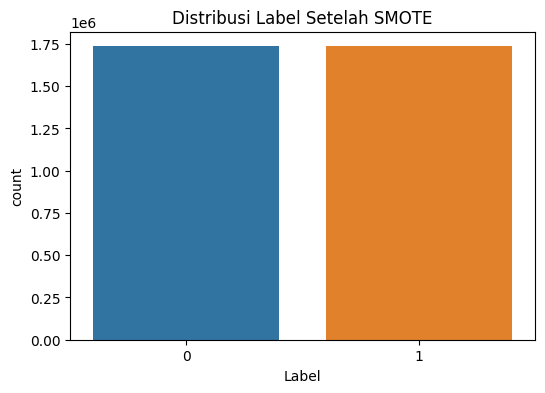

In [19]:
# 6. Visualisasi Distribusi Label Setelah SMOTE
plt.figure(figsize=(6, 4))
sns.countplot(x=y_resampled)
plt.title("Distribusi Label Setelah SMOTE")
plt.show()

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2


In [34]:
print("Building CNN model...")
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_resampled.shape[1],), kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dense(1, activation='sigmoid')
])


Building CNN model...


In [38]:
# Kompilasi model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

In [39]:
# Early stopping untuk mencegah overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [40]:
 #Cek apakah GPU tersedia
print("GPU Available:", tf.config.list_physical_devices('GPU'))

GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [41]:
# Latih model menggunakan GPU (jika tersedia)
print("Training model...")
history = model.fit(
    X_resampled, y_resampled,
    epochs=5,
    batch_size=64,  # Gunakan batch kecil untuk memanfaatkan GPU secara optimal
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],
    verbose=1
)

Training model...
Epoch 1/5
54228/54228 ━━━━━━━━━━━━━━━━━━━━ 95s 2ms/step - accuracy: 0.9577 - loss: 0.3793 - val_accuracy: 0.9901 - val_loss: 0.0812
Epoch 2/5
54228/54228 ━━━━━━━━━━━━━━━━━━━━ 90s 2ms/step - accuracy: 0.9878 - loss: 0.0877 - val_accuracy: 0.9923 - val_loss: 0.0699
Epoch 3/5
54228/54228 ━━━━━━━━━━━━━━━━━━━━ 90s 2ms/step - accuracy: 0.9906 - loss: 0.0754 - val_accuracy: 0.9951 - val_loss: 0.0613
Epoch 4/5
54228/54228 ━━━━━━━━━━━━━━━━━━━━ 90s 2ms/step - accuracy: 0.9917 - loss: 0.0689 - val_accuracy: 0.9953 - val_loss: 0.0573
Epoch 5/5
54228/54228 ━━━━━━━━━━━━━━━━━━━━ 90s 2ms/step - accuracy: 0.9922 - loss: 0.0646 - val_accuracy: 0.9953 - val_loss: 0.0542


In [42]:
# Evaluasi model
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")

Loss: 0.0542, Accuracy: 0.9953


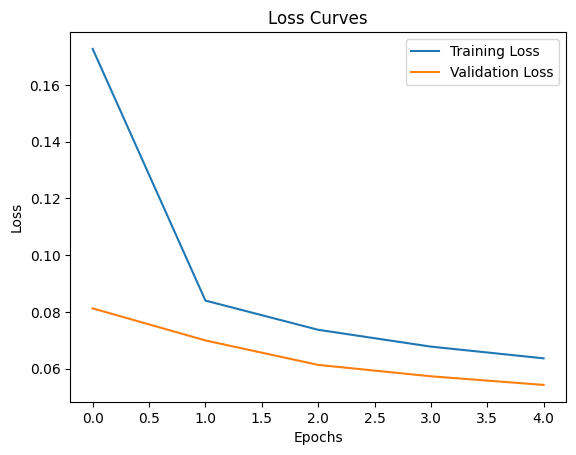

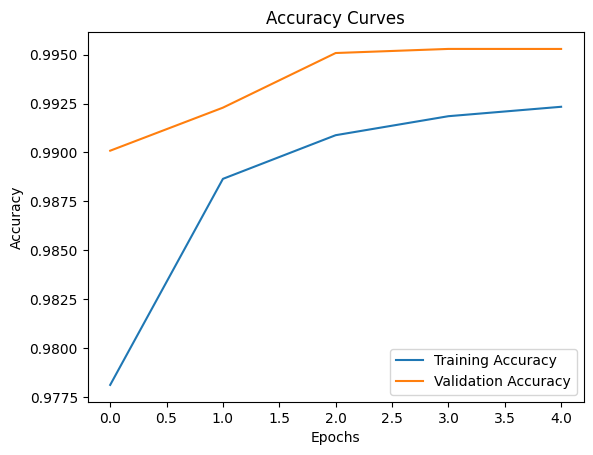

In [43]:
import matplotlib.pyplot as plt

# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curves')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [44]:
# Laporan klasifikasi
y_pred = (model.predict(X_test) > 0.5).astype(int)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

21176/21176 ━━━━━━━━━━━━━━━━━━━━ 25s 1ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    243799
           1       1.00      1.00      1.00    433821

    accuracy                           1.00    677620
   macro avg       1.00      0.99      0.99    677620
weighted avg       1.00      1.00      1.00    677620

